## Compare detection and equilibrium times across different host population sizes

In [1]:
import os
import sys
import getopt
import json
from datetime import datetime
import pandas as pd
import numpy as np

from lib.preferences import *
from lib.response import *
from lib.plotting import *

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for legend
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

## Settings

In [2]:
genetic_metrics = list(genetic_names.keys())
genetic_names.update(op_names)

In [3]:
output_dir = "../figs/review/analysis_cf-popn-size"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
savefig = True

## Load data

In [4]:
input_dir = "../analysis"
expt = "gamma"
focus = "crash"
stat = "detection"

In [5]:
titles = {
    "gamma": "Vary Clearance Rate ($\gamma$)",
    "nv": "Vary No. Vectors ($N_V$)",
    "bite_rate_per_v": "Vary Bite Rate ($b$)"
}

xlabs = {
    "detection" : "Detection Time [Years]",
    "equilibrium" : "Equilibrium Time [Years]"
}

intv_names = {
    "big" : "$N_H=$%d" % 1000,
    "medium" : "$N_H=$%d" % 700,
    "small" : "$N_H=$%d" % 400,
}

pal = "Set1"
intv_cols = dict(zip(intv_names.keys(), sns.color_palette(pal, 3)))

In [6]:
df_big = pd.read_csv(os.path.join(input_dir, 
                                  "2021-02-08_intv-%s" % expt, 
                                  "response",
                                  "%s_%s.csv" % (focus, stat))) 

In [7]:
df_med = pd.read_csv(os.path.join(input_dir, 
                                  "2021-02-18_intv-medium-%s" % expt, 
                                  "response",
                                  "%s_%s.csv" % (focus, stat))) 

In [8]:
df_small = pd.read_csv(os.path.join(input_dir, 
                                    "2021-02-18_intv-small-%s" % expt, 
                                    "response",
                                    "%s_%s.csv" % (focus, stat))) 

In [9]:
df_big

,HX,VX,frac_mixed_samples,mean_k,n_singletons,n_segregating,pi,theta,f_ibd,f_ibs,l_ibs
0,20.025370,45.051128,295.619841,295.619841,1077.849751,195.338170,325.711782,390.796048,661.596563,325.711782,405.856831
1,30.034245,50.050155,265.521067,265.521067,1118.883970,531.171074,1249.571273,1063.723151,867.616045,1249.571273,450.999590
2,25.030576,50.076681,260.456599,205.333497,671.649918,195.322211,932.355839,330.617412,330.617412,932.355839,330.617412
3,25.065066,35.119113,180.310774,180.310774,822.423435,235.420773,1013.116661,511.183982,762.220780,1013.116661,511.183982
4,30.059272,55.076772,230.422174,230.422174,747.322125,300.577855,702.134696,486.271196,481.269496,702.134696,360.842532
...,...,...,...,...,...,...,...,...,...,...,...
93,30.027899,50.061723,205.269821,200.268670,1303.882598,205.269821,230.331163,656.451947,661.465354,230.331163,295.424591
94,30.019056,50.043633,185.333099,185.333099,817.412126,441.087258,3252.366572,712.116260,375.827805,3252.366572,441.087258
95,30.045874,65.099204,200.339655,200.339655,691.829738,385.748963,541.293847,596.452976,601.469037,541.293847,501.160434
96,25.036578,55.076196,280.507172,305.621354,1043.346511,300.582837,712.086830,712.086830,511.263695,712.086830,441.003043


In [10]:
dt = {"big": df_big, "medium": df_med, "small": df_small}

## Munge data

In [11]:
for n, df in dt.items():
    dt[n] = pd.melt(df)
    dt[n].insert(0, "expt", n)

In [12]:
merged_df = pd.concat(dt.values())
metrics = merged_df.variable.unique()
merged_df["variable"] = pd.Categorical(
    merged_df["variable"], metrics, ordered=True)
merged_df["value"] /= 365

In [13]:
# Compute means
mus = merged_df.groupby(["variable", "expt"]).median()
ranks = mus.groupby("expt").rank(method="first")

In [14]:
annot = pd.merge(left=mus, right=ranks, left_index=True, right_index=True)
annot.columns = ["mean", "rank"]
annot.head(21)

mean  rank
variable           expt                  
HX                 big     0.082245   1.0
                   medium  0.082346   1.0
                   small   0.096125   1.0
VX                 big     0.137170   2.0
                   medium  0.151015   2.0
                   small   0.192199   2.0
frac_mixed_samples big     0.645325   3.0
                   medium  0.700313   3.0
                   small   0.667296   3.0
mean_k             big     0.686159   4.0
                   medium  0.727843   4.0
                   small   0.667400   4.0
n_singletons       big     2.348763   9.0
                   medium  1.911732   8.0
                   small   1.516552   7.0
n_segregating      big     1.208157   6.0
                   medium  1.222631   6.0
                   small   1.108884   6.0
pi                 big     2.975341  10.0
                   medium  2.916076  10.0
                   small   2.647651  10.0

## Strip plot

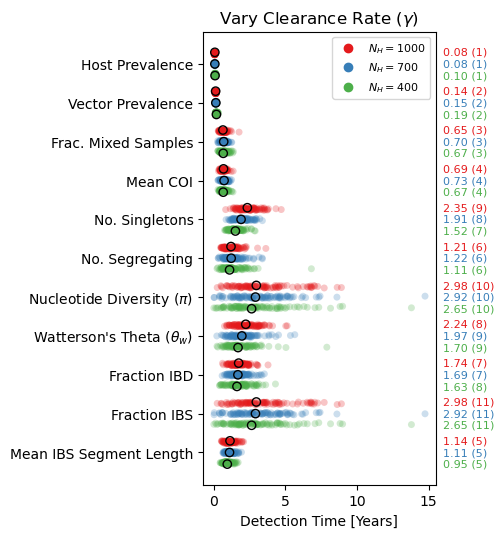

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))

# Stripplot
sp = sns.stripplot(x="value", y="variable", hue="expt",
                   orient="horizontal",
                   palette=pal,
                   alpha=0.25,
                   dodge=True,
                   zorder=0,
                   data=merged_df)


# Means and annotation
shift = 0.3
dodges = np.linspace(-shift, shift, 3)
for d, n in zip(dodges, intv_names.keys()):
    # Median
    ax.scatter(y=sp.get_yticks() + d,
               x=annot.query("expt == @n")["mean"],
               marker="o",
               color='none',
               edgecolor="black",
               zorder=6)
    
    # Annotate
    for i, (m, v) in enumerate(annot.query("expt == @n").iterrows()):
        ax.annotate(xy=(sp.get_xlim()[1], sp.get_yticks()[i] + d),
                    xycoords="data",
                    ha="left", va="center",
                    color=intv_cols[n],
                    fontsize=8,
                    text="  %.2f (%d)" % (v["mean"], v["rank"]))

# Labels
ax.set_ylabel("")
ax.set_xlabel(xlabs[stat])
ax.set_title(titles[expt])

# Legend
handles = [Line2D([0],[0], marker='o', lw=0, color=c, label=intv_names[n])
           for n, c in intv_cols.items()]
ax.legend(handles=handles, fontsize=8)

ax.set_yticklabels([genetic_names[m.get_text()] for m in ax.get_yticklabels()])

if savefig:
    fig.savefig(os.path.join(output_dir, 
                             "%s_%s-%s_stripplot.png" % (expt, focus, stat)),
                bbox_inches="tight", pad_inches=0.5)
    fig.savefig(os.path.join(output_dir, 
                             "%s_%s-%s_stripplot.pdf" % (expt, focus, stat)),
                bbox_inches="tight", pad_inches=0.5)